In [131]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
% matplotlib inline

### 数据处理

In [ ]:
train = pd.read_csv('data/census-income.csv')
train

In [ ]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1],
                                    size=(train.shape[0],))

train_indices = train[train.loc[:, "Set"] == "train"].index  # 训练数据集索引
valid_indices = train[train.loc[:, "Set"] == "valid"].index  # 验证数据集索引
test_indices = train[train.loc[:, "Set"] == "test"].index  # 测试数据集索引

In [ ]:
nunique = train.nunique()
nunique

In [ ]:
types = train.dtypes
types

In [ ]:
categorical_columns = []  # 分类特征
categorical_dims = {}  # 分类特征和该特征唯一值数量
for col in train.columns:
    # 分类特征处理
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()  # 标签二值化
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        # 非分类特征缺失值处理
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

print(categorical_columns)
print(categorical_dims)

In [110]:
# 标签处理
target = ' <=50K'
train.loc[train[target] == 0, target] = "wealthy"
train.loc[train[target] == 1, target] = "not_wealthy"

In [111]:
unused_feat = ['Set']

# 特征
features = [col for col in train.columns if col not in unused_feat + [target]]

# 分类特征id
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

# 每个分类特征唯一值数量
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [112]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [113]:
### TabNetClassifier模型

In [114]:
clf = TabNetClassifier(
    # 分类特征索引列表;默认值[]
    cat_idxs=cat_idxs,
    # 每个分类特征唯一值数量;默认值[]
    cat_dims=cat_dims,
    # pytorch优化器;默认torch.optim.Adam
    optimizer_fn=torch.optim.Adam,
    # pytorch优化器参数
    optimizer_params=dict(lr=2e-2),
    # pytorch学习率调整
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    # pytorch学习率调整对于参数
    scheduler_params={"step_size": 50,  # how to use learning rate scheduler
                      "gamma": 0.9},
    # this is the masking function to use for selecting features.
    # (default='sparsemax') Either "sparsemax" or "entmax"
    mask_type='entmax'
)
clf

Device used : cuda


TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=None, output_dim=None, device_name='auto')

In [118]:
clf.fit(
    X_train=X_train,
    y_train=y_train,
    # List of eval tuple set (X, y).
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    # List of eval set names.
    eval_name=['train', 'valid'],
    # List of evaluation metrics.
    # The last metric is used for early stopping.
    # binary classification metrics : 'auc', 'accuracy', 'balanced_accuracy', 'logloss'
    # multiclass classification : 'accuracy', 'balanced_accuracy', 'logloss'
    # regression: 'mse', 'mae', 'rmse', 'rmsle'
    eval_metric=['auc'],
    # oss function for training (default to mse for regression and cross entropy for classification)
    loss_fn=F.cross_entropy,
    # Maximum number of epochs for trainng.
    max_epochs=1000,  # 默认值200
    # Number of consecutive epochs without improvement before performing early stopping.
    patience=20,  # 默认值15
    # Number of examples per batch. Large batch sizes are recommended.
    batch_size=1024,  # 默认值1024
    # Number or workers used in torch.utils.data.Dataloader
    num_workers=2,  # 默认值0
    # Only for TabNetClassifier Sampling parameter 0 : no sampling 1 : automated sampling with inverse class occurrences dict : keys are classes, values are weights for each class
    weights=1,
    # Whether to drop last batch if not complete during training
    drop_last=False  # 默认值false
)

epoch 0  | loss: 0.31273 | train_auc: 0.93558 | valid_auc: 0.92262 |  0:00:30s
epoch 1  | loss: 0.31627 | train_auc: 0.93776 | valid_auc: 0.92528 |  0:00:41s
epoch 2  | loss: 0.31923 | train_auc: 0.93342 | valid_auc: 0.9225  |  0:00:52s
epoch 3  | loss: 0.32288 | train_auc: 0.90464 | valid_auc: 0.88927 |  0:01:03s
epoch 4  | loss: 0.3189  | train_auc: 0.93742 | valid_auc: 0.92767 |  0:01:14s
epoch 5  | loss: 0.31342 | train_auc: 0.93917 | valid_auc: 0.92622 |  0:01:45s
epoch 6  | loss: 0.3203  | train_auc: 0.93865 | valid_auc: 0.92368 |  0:01:57s
epoch 7  | loss: 0.31095 | train_auc: 0.93978 | valid_auc: 0.92713 |  0:02:08s
epoch 8  | loss: 0.31703 | train_auc: 0.93965 | valid_auc: 0.92645 |  0:02:19s
epoch 9  | loss: 0.31638 | train_auc: 0.93729 | valid_auc: 0.92558 |  0:02:30s
epoch 10 | loss: 0.31126 | train_auc: 0.9393  | valid_auc: 0.92603 |  0:02:42s
epoch 11 | loss: 0.31416 | train_auc: 0.94012 | valid_auc: 0.92589 |  0:02:53s
epoch 12 | loss: 0.30375 | train_auc: 0.94093 | vali

### 结果分析

In [ ]:
clf.history

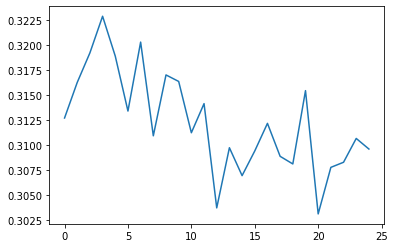

In [120]:
# plot losses
plt.plot(clf.history['loss'])

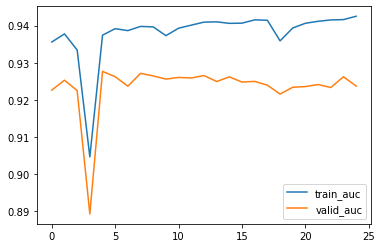

In [123]:
# plot auc
plt.plot(clf.history['train_auc'], label="train_auc")
plt.plot(clf.history['valid_auc'], label="valid_auc")
plt.legend()

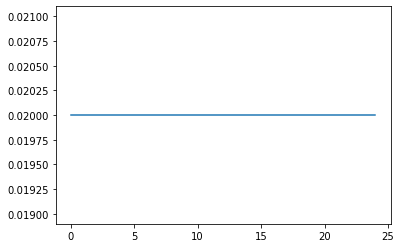

In [122]:
# plot learning rates
plt.plot(clf.history['lr'])

In [127]:
dataset_name = 'census-income'
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:, 1], y_true=y_test)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:, 1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9276657993935479
FINAL TEST SCORE FOR census-income : 0.9247857504228778


In [132]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

In [139]:
# 特征的想对重要性
clf.feature_importances_

array([9.96654166e-02, 1.10205676e-02, 4.35952822e-05, 9.59305451e-02,
       2.82291796e-02, 1.52706929e-01, 1.07018043e-01, 1.24005704e-01,
       2.50945580e-02, 3.47026322e-02, 1.93938960e-01, 6.85843127e-02,
       4.87449188e-02, 1.03146381e-02])

### 保存和加载模型

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

In [134]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [138]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:, 1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")
print(loaded_clf.predict(X_test))


FINAL TEST SCORE FOR census-income : 0.9279809692206273
['not_wealthy' 'not_wealthy' 'wealthy' ... 'not_wealthy' 'wealthy'
 'wealthy']
